In [1]:
## Загрузка необходимых библиотек 
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import random
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from scipy import stats
import tldextract
RANDOM_SEED=42
random.seed(RANDOM_SEED)


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix


# Разведочный анализ и препроцессинг данных

## Разведочный анализ

In [3]:
df_main = pd.read_csv(r'main.csv', encoding='windows-1251')

In [4]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4496 entries, 0 to 4495
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subscriber_id                   4496 non-null   int64  
 1   onnet_traffic                   4496 non-null   float64
 2   onnet_in_traffic                4496 non-null   float64
 3   offnet_traffic                  4496 non-null   float64
 4   offnet_in_traffic               4496 non-null   float64
 5   data_traffic                    4496 non-null   float64
 6   region_id                       4419 non-null   float64
 7   date_of_birth                   4393 non-null   object 
 8   age                             4393 non-null   float64
 9   gender                          4413 non-null   object 
 10  device_type                     3257 non-null   object 
 11  trpl_id                         4496 non-null   int64  
 12  +Tik Tok                        1 

Text(0.5, 1.0, 'Clients age histogram')

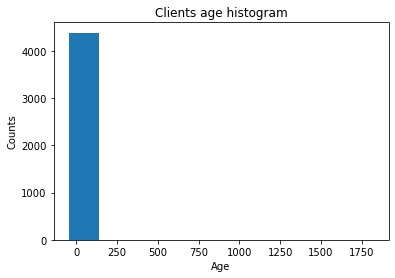

In [5]:
plt.hist(df_main.age, range=[min(df_main.age), max(df_main.age)])
plt.xlabel('Age')
plt.ylabel('Соunts')
plt.title('Clients age histogram')

In [6]:
print('Min and max clients age: ', [min(df_main.age), max(df_main.age)])

Min and max clients age:  [-44.0, 1820.0]


In [7]:
df_main.query('age>=16 & age<=100').age.max()

86.0

На гистограме представленных в наборе данных возрастов видно, что присутствуют промахи - отрицательный возраст и возрат более 100 лет. Визуальный анализ записей которым соответствуют промахи, показывает, что ошибка допущена при указании даты рождения клиента. Данные о возрасте таких клиентов восстановить не представляется возможным.

Согласно законодательству РТ и принципам компании T-cell получить услуги компании можно при наличии паспорта, который в республике можно получить с 16 лет. Этот возраст следует выбрать в качестве нижнего предела при отсечении выбросов. В диапазоне от 16 до 100 лет максимальным возрастом является возраст в 86 лет.

В колонке region_id наблюдаются отсутствующие значения, поскольку эти данные не имеют функционального связанных переменных и не являются врменными, их восстановление также не представляется возможным.

Данные в колонке date_of_birth функционально связаны с данными в колонке age, дальнейшее их использование не является необходимым.

In [8]:
## Удаление выбросов по возрасту, строк с отсутсвующими значениями 'gender', 'region_id', 'date_of_birth'

In [9]:
age_16=df_main.loc[df_main['age']<16]
age_100=df_main.loc[df_main['age']>100]

In [10]:
new_df=df_main.drop(age_16.index)
new_df=new_df.drop(age_100.index)

In [11]:
new_df=new_df.dropna(subset=['age', 'gender', 'region_id'])

In [12]:
new_df=new_df.drop('date_of_birth', axis=1)

In [13]:
## проверка на отсутсвующие значения

new_df.isnull().sum()

subscriber_id                        0
onnet_traffic                        0
onnet_in_traffic                     0
offnet_traffic                       0
offnet_in_traffic                    0
data_traffic                         0
region_id                            0
age                                  0
gender                               0
device_type                       1112
trpl_id                              0
+Tik Tok                          4261
+YouTube                          4253
+Мессенджеры                      4258
+Социальные сети                  4260
Intech - музыкальный плеер        4243
Intech RBT                        4024
Tik-Tok 2.0                       4243
YouTube 2.0                       3800
Бастаи G+1000                     4251
Бастаи G+10000                    4256
Бастаи G+2000                     4253
Бастаи G+4000                     4256
Бастаи G+500                      4147
Бастаи G+6000                     4259
Бастаи G1000             

In [14]:
new_df.shape

(4261, 45)

In [15]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4261 entries, 0 to 4495
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subscriber_id                   4261 non-null   int64  
 1   onnet_traffic                   4261 non-null   float64
 2   onnet_in_traffic                4261 non-null   float64
 3   offnet_traffic                  4261 non-null   float64
 4   offnet_in_traffic               4261 non-null   float64
 5   data_traffic                    4261 non-null   float64
 6   region_id                       4261 non-null   float64
 7   age                             4261 non-null   float64
 8   gender                          4261 non-null   object 
 9   device_type                     3149 non-null   object 
 10  trpl_id                         4261 non-null   int64  
 11  +Tik Tok                        0 non-null      float64
 12  +YouTube                        8 

## Препроцессинг и выделение фитч

In [16]:
# Данные не включая опции 

df_data=new_df.iloc[:,:11]

Значения NaN в наборе данных опций эквиваленты 0 - т.е. опция не подключена.

In [17]:
# Данные по подключенным опциям 

df_option= new_df.iloc[:,11:]
df_option=df_option.fillna(0)

In [18]:
df_main.device_type.unique()

array(['Unidentified Devices', '4G Smartphones', nan, '3G Modems/Routers',
       'Smartphones', '3G Smartphones', '2G Non-Data Phones',
       '2G Smartphones', '4G Tablets', '2G Feature Phones', '3G Tablets',
       '3G Feature Phones'], dtype=object)

В результате анализа колонки device_type обнаружено наличие NaN объектов, в данном случае NaN равносильно категории Unidentified Devices.

In [19]:
df_data=df_data.fillna('Unidentified Devices')

Создание дополнительной фитчи - opt_spend, содержащей информацию о доходах компании от доп опций (расходы клиента).  Данные получены из открытых испочников.

In [20]:
# Cтоимость каждой опции в последовательности столбцов датафрейма df_option

num_opt=[50, 50, 10, 50, 11, 12, 70 ,60 ,25, 112, 38, 63, 13, 85, 20, 100, 30, 150, 10, 40, 60, 300, 74, 60, 30, 2, 20, 15, 30, 15, 60, 70, 99, 80]

In [21]:
## Замена 1 в столбце на соответвующую стоимость в сом, общая потраченная сумма на опции opt_spend
df_option_copy=df_option.copy()
for i, col in enumerate(df_option.columns):
    df_option_copy.loc[df_option[col]==1,col]=num_opt[i]
        

In [22]:
opt_spend=df_option_copy.sum(axis=1)

In [23]:
opt_spend=pd.DataFrame(opt_spend, columns=['spend_option'])

In [24]:
dataset=pd.concat([df_data, opt_spend], axis=1 )

In [25]:
opt_spend

,spend_option
0,10.0
1,60.0
2,15.0
3,10.0
4,10.0
...,...
4491,60.0
4492,80.0
4493,10.0
4494,100.0


In [26]:
dataset=dataset.reset_index()


In [27]:
dataset['region_id'][dataset['region_id']==-5000]=-1

C:\Users\darya\AppData\Local\Temp/ipykernel_4964/19955386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['region_id'][dataset['region_id']==-5000]=-1


# Клиентский анализ

In [28]:
#числовые данные: 
data_float=dataset.T.loc[(dataset.dtypes=='float64')].T
#data_float=data_float.drop('subscriber_id', axis=1)
data_int=dataset.T.loc[(dataset.dtypes=='int64')].T

In [29]:
data_float=pd.concat([data_float, data_int['trpl_id']], axis =1)

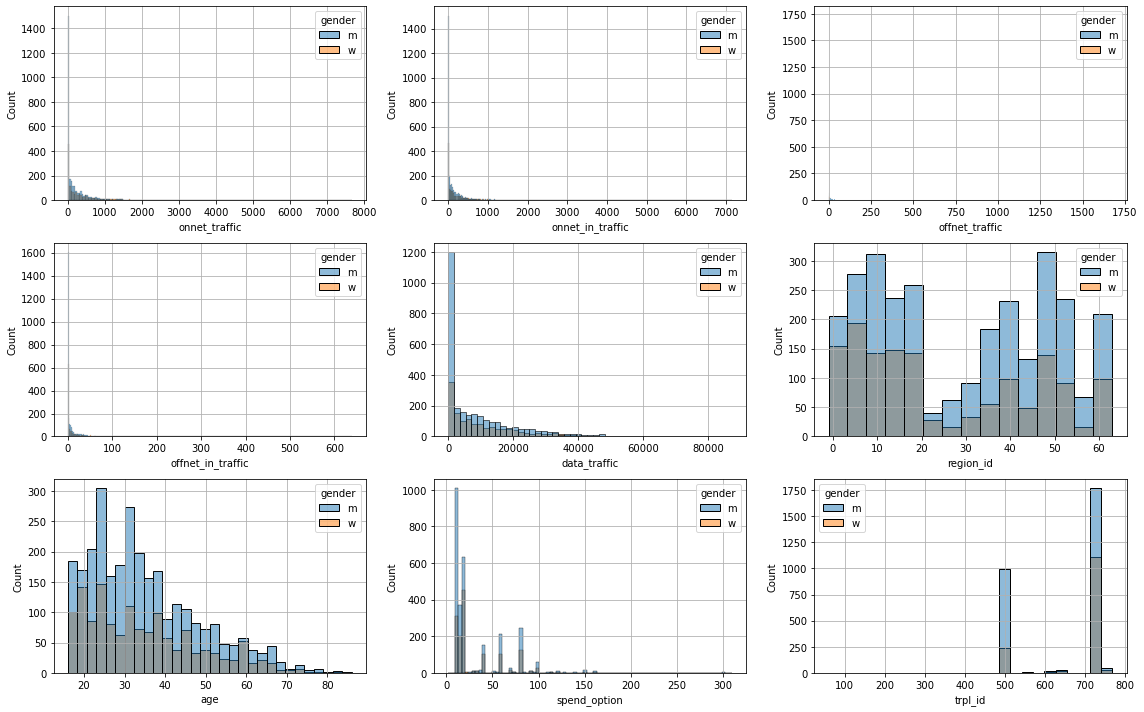

In [30]:
plt.figure(figsize=(16, 10))
for i in np.arange(0,9):
    plt.subplot(3,3,i+1)
    sns.histplot(data=dataset, x =data_float.columns[i], hue='gender')
    plt.grid(True)
    plt.tight_layout()
plt.savefig('all_hits')

Исходя из гистограммы на: наиболее частый клиент - ~24 или ~32 года, мужского пола; Наиболее популярный тариф 720 или 491 тариф. 
Пользователь готов тратить 10-20 сомон в месяц на дополнительные опции, а также использует трафик до 4 000 МгБт/ Наиболее предпочтительные опции: Бастаи G1000, Мессенджеры 2.0, Бастаи G250.



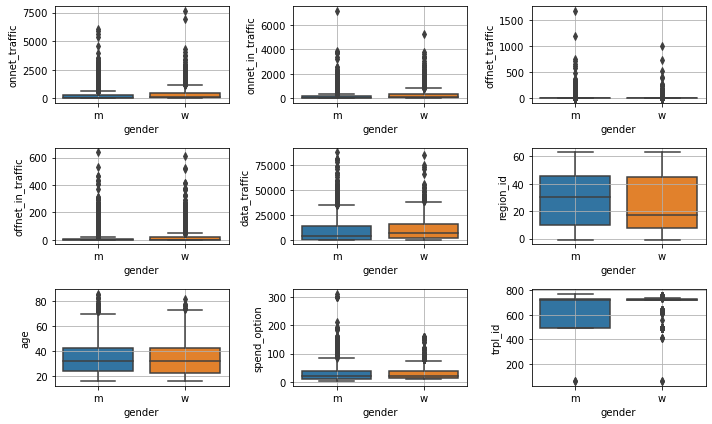

In [31]:
plt.figure(figsize=(10, 6))
for i in np.arange(0,9):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=dataset, x='gender', y=data_float.columns[i],width = 0.8)
    plt.grid(True)
    plt.tight_layout()
plt.savefig('boxplot')

Пол среди разных возрастных групп распределен с одинаковой частотой. 
Пользователь – мужчина готов делать больше более дорогих трат на платные опции, нежели женщина; медиана, а также верхний и нижний наблюдаемый уровень трафика у пользователей разного пола примерно одинаков. 

In [32]:
# object данные: 
data_obj=dataset.T.loc[(dataset.dtypes=='object')].T

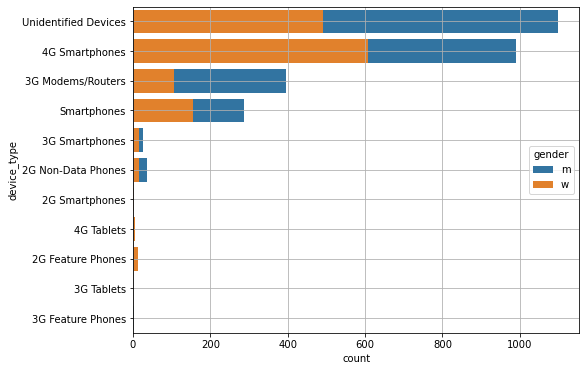

In [33]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data_obj, y='device_type', hue='gender', dodge=False)
plt.grid(True)
plt.savefig('count')

## Получение категориальных переменных из столбцов 'device_type','gender'

In [34]:
from sklearn.preprocessing import OneHotEncoder
def nom_class(data):
    nom_enc = OneHotEncoder(sparse=False)
    categorical_columns = list(['device_type','gender'])
    encoded_data = nom_enc.fit_transform(data[categorical_columns])
    encoded_df = pd.DataFrame(encoded_data.astype(int), columns=nom_enc.get_feature_names_out(categorical_columns))
    return encoded_df

In [35]:
data_class=nom_class(dataset)

In [36]:
data_class

,device_type_2G Feature Phones,device_type_2G Non-Data Phones,device_type_2G Smartphones,device_type_3G Feature Phones,device_type_3G Modems/Routers,device_type_3G Smartphones,device_type_3G Tablets,device_type_4G Smartphones,device_type_4G Tablets,device_type_Smartphones,device_type_Unidentified Devices,gender_m,gender_w
0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4256,0,1,0,0,0,0,0,0,0,0,0,0,1
4257,0,0,0,0,0,0,0,1,0,0,0,0,1
4258,0,0,0,0,1,0,0,0,0,0,0,0,1
4259,0,0,0,0,0,0,0,1,0,0,0,1,0


In [37]:
## окончательный датасет
dataset_fin=pd.concat([dataset, data_class], axis=1)

In [38]:
dataset_fin.shape

(4261, 26)

In [39]:
dataset_fin=dataset_fin.drop(['device_type', 'gender'], axis=1)

## Корреляционный анализ

H0 - выборки не коррелированы; 
H1 - выборки коррелированы; 
H0 отвергается при  pvalue< 95% уровня, то есть 0.05

In [40]:
#Корреляция 'device_type' с возрастом 
for i in data_class.columns:
    print(i)
    print(stats.pointbiserialr(data_class[i], dataset['age']))

device_type_2G Feature Phones
PointbiserialrResult(correlation=0.00025327164637666336, pvalue=0.9868133281968862)
device_type_2G Non-Data Phones
PointbiserialrResult(correlation=-0.019695425732474542, pvalue=0.19865509560679467)
device_type_2G Smartphones
PointbiserialrResult(correlation=0.010097211000339307, pvalue=0.5099392114844719)
device_type_3G Feature Phones
PointbiserialrResult(correlation=0.010234483664438096, pvalue=0.5042031272114296)
device_type_3G Modems/Routers
PointbiserialrResult(correlation=0.13932849566271466, pvalue=6.433853439853113e-20)
device_type_3G Smartphones
PointbiserialrResult(correlation=-0.01602186919156967, pvalue=0.2957415137685976)
device_type_3G Tablets
PointbiserialrResult(correlation=-0.026668021948730636, pvalue=0.08175555102835284)
device_type_4G Smartphones
PointbiserialrResult(correlation=-0.1252444180033876, pvalue=2.297765773300402e-16)
device_type_4G Tablets
PointbiserialrResult(correlation=0.004999200497101642, pvalue=0.7442459695552707)
devi

макс коэф корреляции при pvalue<< 0.05 -  H0  отвергается и данные фичи используется в дальнейшем; 

In [41]:
#Корреляция опций с возрастом 
for i in df_option.columns:
    print(i)
    print(stats.pointbiserialr(df_option[i], df_data['age']))

+Tik Tok
PointbiserialrResult(correlation=nan, pvalue=nan)
+YouTube
PointbiserialrResult(correlation=-0.014438141003717393, pvalue=0.3460689963282779)
+Мессенджеры
PointbiserialrResult(correlation=-0.013667642545167504, pvalue=0.3724178465945695)
+Социальные сети
PointbiserialrResult(correlation=0.03559575064063944, pvalue=0.020146150382496814)
Intech - музыкальный плеер
PointbiserialrResult(correlation=0.006381187588594205, pvalue=0.6771008155766487)
Intech RBT
PointbiserialrResult(correlation=-0.055894049030556704, pvalue=0.0002618914352916832)
Tik-Tok 2.0
PointbiserialrResult(correlation=-0.018802650951641596, pvalue=0.21977879966924657)
YouTube 2.0
PointbiserialrResult(correlation=-0.001979190746411435, pvalue=0.8972337836123879)
Бастаи G+1000
PointbiserialrResult(correlation=-0.023418002746403373, pvalue=0.12641263681574771)
Бастаи G+10000
PointbiserialrResult(correlation=-0.0041142608997702, pvalue=0.7883250837865416)
Бастаи G+2000
PointbiserialrResult(correlation=-0.005206009280

C:\Users\darya\anaconda3\envs\tf-gpu\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


максимальный коэф корреляции при фиче Бастаи G250:
correlation=0.21530, pvalue=7.172865e-46);
Данная фича используется в дальнейшем; 

In [42]:
#Корреляция трафика с возрастом 
for i in dataset.columns:
    print(i)
    print(stats.spearmanr(dataset[i],dataset_fin['age']))

index
SpearmanrResult(correlation=-0.010303879287474654, pvalue=0.50131635871828)
subscriber_id
SpearmanrResult(correlation=-0.010303879287474654, pvalue=0.50131635871828)
onnet_traffic
SpearmanrResult(correlation=-0.24932569253602901, pvalue=2.1572057584775742e-61)
onnet_in_traffic
SpearmanrResult(correlation=-0.234275995083389, pvalue=3.236930618744641e-54)
offnet_traffic
SpearmanrResult(correlation=-0.14599096103215944, pvalue=9.863869473651264e-22)
offnet_in_traffic
SpearmanrResult(correlation=-0.1996504764947786, pvalue=1.4646025269621814e-39)
data_traffic
SpearmanrResult(correlation=-0.18417581481535628, pvalue=8.014025777875766e-34)
region_id
SpearmanrResult(correlation=0.011069742144769424, pvalue=0.4700471554564716)
age
SpearmanrResult(correlation=1.0, pvalue=0.0)
gender
SpearmanrResult(correlation=-0.015856821478372866, pvalue=0.3007452419648898)
device_type
SpearmanrResult(correlation=-0.0021421403997672773, pvalue=0.8888257486079404)
trpl_id
SpearmanrResult(correlation=-0.1

С возрастом коррелируют все данные трафика, расходы

In [43]:
#Корреляция по wilcoxon между номером региона и возрастом;
from scipy.stats import wilcoxon
wilcoxon(dataset['region_id'], dataset['age'])

WilcoxonResult(statistic=3177695.0, pvalue=2.7847621299038445e-58)

Корреляция есть

In [44]:
#Корреляция по wilcoxon между номером тарифа и возрастом;
wilcoxon(dataset['trpl_id'], dataset['age'])

WilcoxonResult(statistic=0.0, pvalue=0.0)

Корреляции нет 

## Работа с опциями

In [45]:
## Кол-во клиентов, которые подключили данную опцию
df_option.sum().sort_values()

+Tik Tok                             0.0
Диери ман 2016                       0.0
Мегабайты за звонки                  1.0
Бастаи G2000                         1.0
+Социальные сети                     1.0
Бастаи G+6000                        2.0
Тройной Безлимит+Тикток              2.0
+Мессенджеры                         3.0
Безлимитный Смартфон 2016            4.0
Тройной безлимит                     5.0
Бастаи G+10000                       5.0
Бастаи G+4000                        5.0
Бастаи G50000                        5.0
Соц. сети 2.0                        7.0
+YouTube                             8.0
Бастаи G+2000                        8.0
Бастаи G+1000                       10.0
Ночной безлимитный интернет         11.0
Безлимитный Смартфон Lite 2016      14.0
Intech - музыкальный плеер          18.0
Tik-Tok 2.0                         18.0
Бастаи G20000                       20.0
Соц. сети 2.0+                      41.0
Опция T-Games                       61.0
Бастаи G10000   

In [46]:
## Корреляция распространенных опций между собой 

In [47]:
opt_dr=df_option.sum().sort_values().index[:9]

In [48]:
opt_new=df_option.copy()

In [49]:
opt_new=opt_new.drop(labels=opt_dr, axis = 1)

In [50]:
from scipy.stats import chi2_contingency
resalt_i=list()
resalt_neg=list()
for i in opt_new.columns:
    for j in opt_new.columns:
        CrosstabResult=pd.crosstab(opt_new[i], opt_new[j])
        ChiSqResult = chi2_contingency(CrosstabResult)
        if ChiSqResult[1]<0.05:
            if i!=j:
                resalt_i.append(i)
        else:
            resalt_neg.append(i)

In [51]:
pd.Series(resalt_i).value_counts()

Бастаи G250                    14
Мессенджеры 2.0                12
Муоширати озод                 10
YouTube 2.0                     9
Intech RBT                      8
Бастаи G5000                    7
Бастаи G+500                    7
Бастаи G1000                    7
Бастаи G10000                   6
Бастаи G3000                    6
Бастаи G+2000                   4
Опция T-Games                   3
Соц. сети 2.0+                  3
Бастаи G20000                   3
Бастаи G+4000                   3
Бастаи G+1000                   2
Бастаи G+10000                  1
Ночной безлимитный интернет     1
Tik-Tok 2.0                     1
Intech - музыкальный плеер      1
dtype: int64

## Создание датафрейма с валидными фичами

In [52]:
data_tr=dataset_fin[['onnet_traffic', 'onnet_in_traffic', 'offnet_traffic','offnet_in_traffic', 'data_traffic', 
            'region_id','device_type_3G Modems/Routers', 'device_type_4G Smartphones',  'spend_option', 'age']]

In [53]:
data_opt=df_option['Бастаи G250']

In [54]:
data_opt = data_opt.reset_index()

In [55]:
data= pd.concat([data_opt, data_tr], axis=1 )

In [56]:
data=data.drop(['index'], axis =1)
data

,Бастаи G250,onnet_traffic,onnet_in_traffic,offnet_traffic,offnet_in_traffic,data_traffic,region_id,device_type_3G Modems/Routers,device_type_4G Smartphones,spend_option,age
0,1.0,0.00,0.00,0.00,0.00,3.30,54.0,0,0,10.0,40.0
1,0.0,18.42,6.33,5.67,3.87,9165.39,52.0,0,1,60.0,19.0
2,0.0,421.05,673.50,5.30,2.13,18746.59,6.0,0,0,15.0,20.0
3,1.0,0.00,0.00,0.00,0.00,26.81,8.0,0,0,10.0,51.0
4,1.0,0.00,0.00,0.00,0.00,91.67,17.0,0,0,10.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...
4256,0.0,2012.62,169.80,1.52,0.00,1672.91,6.0,0,0,60.0,28.0
4257,0.0,310.93,334.90,1.25,92.82,12171.90,37.0,0,1,80.0,28.0
4258,1.0,0.00,0.00,0.00,0.00,33.29,29.0,1,0,10.0,49.0
4259,0.0,206.58,18.53,4.02,6.10,20279.11,37.0,0,1,100.0,29.0


## Построение моделей

In [57]:
# приведение данных к одному диапазону - нормализация данных

def scal(dataset_fin):
    scaler=MinMaxScaler()
    scaler.fit(dataset_fin)
    scaled = scaler.transform(dataset_fin)
    scaled = pd.DataFrame(scaled, index=dataset_fin.index, columns=dataset_fin.columns)
    scaled=scaled.reset_index()
    scaled=scaled.drop(['index'], axis =1)
    return scaled, scaler

In [58]:
data_sc, scaler= scal(data)

In [59]:
# Получение тренировочного и тестового набора данных 

def split_reg(scaled_data):
    train_df, test_df = train_test_split(scaled_data, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)
    return train_df, test_df

In [60]:
train_df, test_df=split_reg(data_sc)

In [61]:
#функция разделения данные на лейблы и данные 

def targ(data_tr, df_train, df_test):
    TARGET_COLUMN = 'age'
    x_columns = data_tr.columns
    x_columns = x_columns[x_columns != TARGET_COLUMN]
    y_scal_tren = df_train[TARGET_COLUMN]
    X_scal_tren = df_train[x_columns]
    y_scal_test = df_test[TARGET_COLUMN]
    X_scal_test = df_test[x_columns]
    return y_scal_tren, X_scal_tren, y_scal_test,  X_scal_test  

In [62]:
train_labels, train_data, test_labels, test_data = targ(data_sc, train_df, test_df,)

### Регрессионная модель

In [63]:
# Получение метрик 
def metrics(train_labels, train_data, test_labels, test_data, model):
    model.fit(train_data, train_labels)
    y_pred = model.predict(test_data)
    r2 = r2_score(test_labels, y_pred)
    mse=mean_squared_error(test_labels, y_pred)
    mae=mean_absolute_error(test_labels, y_pred)
    var_dict = {
        'mae_score' : mae,
        'r2_score' : r2,
        'mse_score' : mse
        
    }
    return var_dict, y_pred, test_labels

In [64]:
reg_model = LinearRegression()
var_dict, y_pred, test_labels=metrics(train_labels, train_data, test_labels, test_data, reg_model )

In [65]:
var_dict

{'mae_score': 0.15183979175121265,
 'r2_score': 0.061534296000651745,
 'mse_score': 0.03562789116430506}

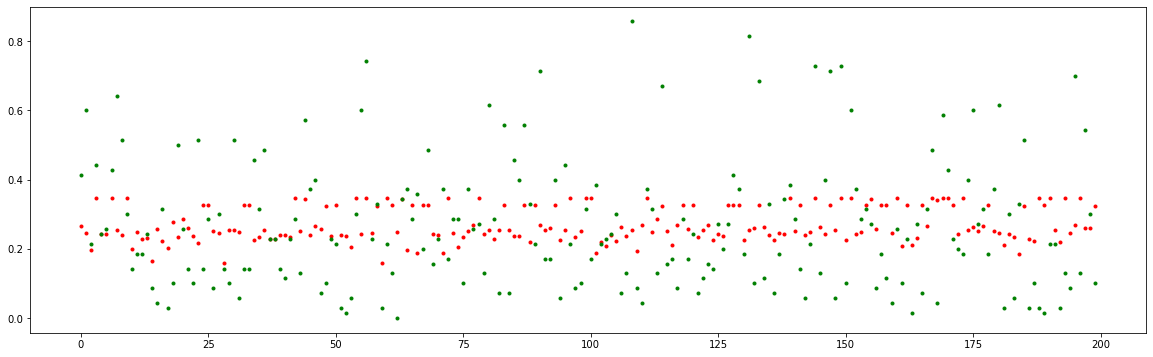

In [66]:
## График спрогнозированных значений с помощью линейной модели 
plt.figure(figsize=(20, 6))
x = np.arange(len(y_pred[:200]))
plt.plot(x, y_pred[:200],'r.')
plt.plot(x,test_labels[:200], 'g.')
plt.savefig('lin')

### Классификационная модель

In [67]:
## Разделение целевой переменной 'age' на диапазоны [(15.999, 26.0] < (26.0, 38.0] < (38.0, 86.0]],
# превращение в классы [0, 1, 2]
data_class=data_sc.copy()
data_class['age']=pd.qcut(data_class['age'],3, labels=[0, 1, 2])

In [68]:
data_class['age'].value_counts()

0    1453
1    1421
2    1387
Name: age, dtype: int64

In [69]:
def split(data):
    train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['age'], shuffle=True, random_state=RANDOM_SEED)
    return train_df, test_df

In [70]:
df_train, df_test=split(data_class)

In [71]:
y_scal_tren, X_scal_tren, y_scal_test,  X_scal_test  = targ(data_class, df_train, df_test)

In [72]:
#функция обучения модели и получения спрогнозированных значений
from sklearn.metrics import classification_report
def pred(model, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test):
    model.fit(X_scal_tren, y_scal_tren)
    y_pred = model.predict(X_scal_test)
    report = classification_report(y_scal_test, y_pred, digits=5)
    return print(report),  y_pred

In [73]:
# Логистическая регрессия 

log_reg = LogisticRegression(random_state=RANDOM_SEED, max_iter=10000)
_,y_pred_log=pred(log_reg, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

           0    0.40977   0.66323   0.50656       291
           1    0.39552   0.18662   0.25359       284
           2    0.47177   0.42086   0.44487       278

    accuracy                        0.42556       853
   macro avg    0.42569   0.42357   0.40167       853
weighted avg    0.42523   0.42556   0.40223       853



In [74]:
# Модель ближайших соседей 

knn = KNeighborsClassifier(n_neighbors=7)
_,y_pred_knn=pred(knn, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

           0    0.39211   0.51203   0.44411       291
           1    0.35955   0.33803   0.34846       284
           2    0.42233   0.31295   0.35950       278

    accuracy                        0.38921       853
   macro avg    0.39133   0.38767   0.38402       853
weighted avg    0.39112   0.38921   0.38469       853



In [75]:
# Исчерпывающий поиск по заданным значениям параметров

grid_search = GridSearchCV(knn, param_grid={ 'n_neighbors': np.arange(2, 10)},
                           scoring='accuracy',
                           cv=5)
grid_search.fit(X_scal_tren, y_scal_tren)
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=9)

In [76]:
## Модель дерева принятия решений 

dectree = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_SEED)
_,y_pred_dec=pred(dectree, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

           0    0.43704   0.40550   0.42068       291
           1    0.33230   0.37676   0.35314       284
           2    0.42146   0.39568   0.40816       278

    accuracy                        0.39273       853
   macro avg    0.39693   0.39265   0.39399       853
weighted avg    0.39709   0.39273   0.39411       853



In [77]:
## Модель случайного леса 

rf_clf = RandomForestClassifier(max_depth=10, n_estimators=80, max_features='sqrt', 
                                random_state=RANDOM_SEED)
_,y_pred_rf_clf=pred(rf_clf, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

           0    0.44809   0.56357   0.49924       291
           1    0.35371   0.28521   0.31579       284
           2    0.40698   0.37770   0.39179       278

    accuracy                        0.41032       853
   macro avg    0.40293   0.40883   0.40227       853
weighted avg    0.40327   0.41032   0.40314       853



In [78]:
# Исчерпывающий поиск по заданным значениям параметров

grid_search = GridSearchCV(rf_clf, param_grid={ 'max_depth': np.arange(10, 17),
                                               'n_estimators': np.arange(70, 110, step=10)},
                           scoring='accuracy',
                           cv=5)
grid_search.fit(X_scal_tren, y_scal_tren)
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=80,
                       random_state=42)

In [79]:
## Модель градиентного бустинга 

gb_clf = GradientBoostingClassifier(n_estimators=80, max_depth=10, max_features='sqrt', random_state=RANDOM_SEED)
_,y_pred_gb_clf=pred(gb_clf, X_scal_tren, y_scal_tren, X_scal_test, y_scal_test)

              precision    recall  f1-score   support

           0    0.42574   0.44330   0.43434       291
           1    0.33579   0.32042   0.32793       284
           2    0.37634   0.37770   0.37702       278

    accuracy                        0.38101       853
   macro avg    0.37929   0.38047   0.37976       853
weighted avg    0.37970   0.38101   0.38023       853



Лучшая классификационная модель - обычная логистическая регрессия. Её точность составляет 0.44, что в сравнении с basemodel 0.333, точнее на 10% (относительно макс. точности 100%)

<AxesSubplot:>

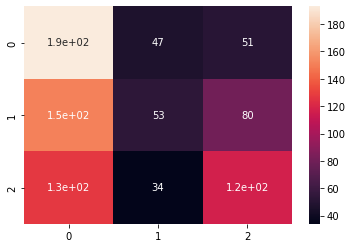

In [80]:
# Матрица ошибок 

cm = confusion_matrix(y_scal_test, y_pred_log)
sns.heatmap(cm, annot=True)

## NEURAl

In [81]:
train_targets= train_labels

In [82]:
# С сохранением оценки проверки при каждом прогоне
from keras import models
from keras import layers


def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

num_epochs=20
all_mae_histories=[]
all_val_mae_histories = []
all_val_loss_histories=[]
all_loss_histories=[]

k=4
num_val_samples=len(train_data)//k

for i in range(k):
    print('processing fold #', i)
    val_data=train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets=train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data=np.concatenate([train_data[:i*num_val_samples],
                                      train_data[(i+1)*num_val_samples:]],
                                     axis=0)
    partial_train_targets=np.concatenate([train_targets[:i*num_val_samples],
                                         train_targets[(i+1)*num_val_samples:]],
                                        axis=0)
    model=build_model()
    history=model.fit(partial_train_data, partial_train_targets, 
                      validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_val_history=history.history['val_mae']
    all_val_mae_histories.append(mae_val_history)
    mse_val_history=history.history['val_loss']
    all_val_loss_histories.append(mse_val_history)
    
    mae_history=history.history['mae']
    all_mae_histories.append(mae_history)
    mse_history=history.history['loss']
    all_loss_histories.append(mse_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [83]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

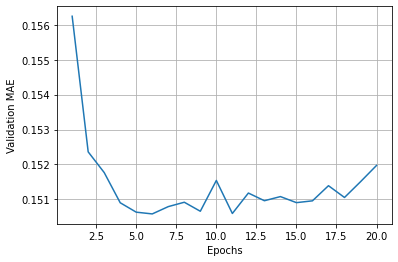

In [84]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.show()

In [85]:
average_loss_history=[np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]

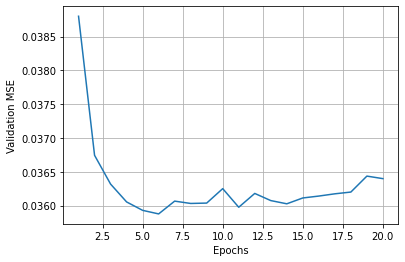

In [86]:
plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MSE')
plt.grid(True)
plt.show()

# Работа с dpi.csv

In [87]:
df_dpi = pd.read_csv(r'dpi.csv')

In [88]:
df_dpi

,subscriber_id,ssl_server_name,data_traffic
0,1765,NaN,24311.0
1,1765,scontent.fdyu2-1.fna.fbcdn.net,2314.0
2,1765,media.fdyu2-1.fna.whatsapp.net,1180.0
3,1765,v16m.tiktokcdn.com,829.0
4,1765,media-arn2-1.cdn.whatsapp.net,490.0
...,...,...,...
949121,2391,rr14---sn-n8v7znsz.googlevideo.com,0.0
949122,2391,rr16---sn-n8v7znsy.googlevideo.com,0.0
949123,2391,static.ads-twitter.com,0.0
949124,2391,somon-bebce.firebaseio.com,0.0


In [89]:
# Проверка на отсутсвующие значения
df_dpi.isnull().sum()

subscriber_id         0
ssl_server_name    1392
data_traffic          0
dtype: int64

In [90]:
# Удаление строк с отсутсвующими значениями
df_dpi.dropna(inplace=True)
df_dpi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947734 entries, 1 to 949125
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   subscriber_id    947734 non-null  int64  
 1   ssl_server_name  947734 non-null  object 
 2   data_traffic     947734 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.9+ MB


In [91]:
# Выделение данных из датафрейма main при совпадении id абонента между файлом main и dpi

main_id_df=new_df.loc[new_df['subscriber_id'].isin(df_dpi.subscriber_id.unique())].copy(deep=True)
main_id_df.reset_index(inplace=True, drop=True)

In [92]:
# Выделение данных из датафрейма dpi при совпадении id абонента между файлом main и dpi

df_dpi=df_dpi.loc[df_dpi['subscriber_id'].isin(new_df.subscriber_id.unique())].copy(deep=True)
df_dpi.reset_index(inplace=True, drop=True)

In [93]:
# сводная таблица  по id абонента

dpi_piv=pd.pivot_table(df_dpi, index='subscriber_id', values=['ssl_server_name', 'data_traffic'], 
                       aggfunc={'ssl_server_name': [len, lambda x: ",".join(str(v) for v in x)], 'data_traffic': np.sum})
dpi_piv

data_traffic                                    ssl_server_name  \
                       sum                                         <lambda_0>   
subscriber_id                                                                   
1                  11376.0  scontent.fdyu2-1.fna.fbcdn.net,instagram.fdyu2...   
7                   7262.0  instagram.fdyu2-1.fna.fbcdn.net,cdn.pvvstream....   
12                 10802.0  rr1---sn-poqpbvuw-qt0s.googlevideo.com,rr2---s...   
18                   780.0  media.fdyu2-1.fna.whatsapp.net,scontent.fdyu2-...   
22                    52.0  rr2---sn-poqpbvuw-qt0s.gvt1.com,media.fdyu2-1....   
...                    ...                                                ...   
4480               20282.0  instagram.fdyu2-1.fna.fbcdn.net,v16m.tiktokcdn...   
4481               15496.0  rr1---sn-poqpbvuw-qt0s.googlevideo.com,api.wea...   
4490                7028.0  instagram.fdyu2-1.fna.fbcdn.net,scontent.fdyu2...   
4492                8340.0  rr2---sn-poqpbvuw-qt0s.googlevideo.com,rr1---s...   
4494                1861.0  rr1---sn-poqpbvuw-qt0s.googlevideo.com,rr2---s...   

                     
                len  
subscriber_id        
1               871  
7               683  
12             1464  
18              130  
22               60  
...             ...  
4480            530  
4481            942  
4490            760  
4492            553  
4494            297  

[1343 rows x 3 columns]

In [94]:
# Получение субдомена, домена и суффикса

cust_dict=dict()
all_list=list()
for num, ind in enumerate(dpi_piv.index):
    cust_dict[ind]=np.array(dpi_piv.ssl_server_name['<lambda_0>'].values[num].split(","))
for ind in cust_dict.keys():
    sub_list=list()
    dom_list=list()
    suf_list=list()
    for string in cust_dict[ind]:
        extracted_info = tldextract.extract(string)
        sub_list.append(extracted_info.subdomain)
        dom_list.append(extracted_info.domain)
        suf_list.append(extracted_info.suffix)
    all_list.append([sub_list, dom_list, suf_list, ind])

In [95]:
# Создание новой фитчи, где присутсвует домен и частота его повторения 

new_fitch_df=pd.DataFrame(all_list, columns=['subdomain', 'domain', 'suffix', 'subscriber_id'])
new_fitch_df.to_csv('new_fitch.csv', index=False)

In [96]:
new_fitch_df

,subdomain,domain,suffix,subscriber_id
0,"[scontent.fdyu2-1.fna, instagram.fdyu2-1.fna, ...","[fbcdn, fbcdn, whatsapp, facebook, tiktokcdn, ...","[net, net, net, com, com, net, com, com, com, ...",1
1,"[instagram.fdyu2-1.fna, cdn, video, i, mm, sco...","[fbcdn, pvvstream, faperoni, instagram, erkiss...","[net, pro, com, com, com, com, pro, net, com, ...",7
2,"[rr1---sn-poqpbvuw-qt0s, rr2---sn-poqpbvuw-qt0...","[googlevideo, googlevideo, googlevideo, google...","[com, com, com, com, com, com, com, com, com, ...",12
3,"[media.fdyu2-1.fna, scontent.fdyu2-1.fna, , gr...","[whatsapp, fbcdn, imo, facebook, whatsapp, goo...","[net, net, im, com, net, com, com, sg, net, ne...",18
4,"[rr2---sn-poqpbvuw-qt0s, media.fdyu2-1.fna, ww...","[gvt1, whatsapp, googleapis, gstatic, facebook...","[com, net, com, com, com, com, net, com, com, ...",22
...,...,...,...,...
1338,"[instagram.fdyu2-1.fna, v16m, v58, media.fdyu2...","[fbcdn, tiktokcdn, tiktokcdn, whatsapp, instag...","[net, com, com, net, com, net, com, com, com, ...",4480
1339,"[rr1---sn-poqpbvuw-qt0s, api, rr1---sn-poqpbvu...","[googlevideo, weathercn, googlevideo, googlevi...","[com, com, com, com, com, net, net, com, com, ...",4481
1340,"[instagram.fdyu2-1.fna, scontent.fdyu2-1.fna, ...","[fbcdn, fbcdn, tiktokcdn, cdninstagram, instag...","[net, net, com, com, com, com, net, io, com, c...",4490
1341,"[rr2---sn-poqpbvuw-qt0s, rr1---sn-poqpbvuw-qt0...","[googlevideo, googlevideo, fbcdn, fbcdn, whats...","[com, com, net, net, net, com, net, com, com, ...",4492


In [97]:
# Длина вектора доменов  

len_sub=list()
for i in range(len(new_fitch_df.domain)):
    len_sub.append(len(pd.Series(new_fitch_df.domain[i]).value_counts().values))
pd.Series(len_sub).value_counts()

132     11
120     10
103     10
97      10
86      10
        ..
871      1
334      1
1300     1
352      1
316      1
Length: 464, dtype: int64

In [98]:
# Выделение 5 наиболее популярных доменов

domain5_list=list()
domain_counts_list=list()
suf5_list=list()
suffix_counts_list=list()
for i in range(len(new_fitch_df.domain)):
    domain5_list.append(list(pd.Series(new_fitch_df.domain[i]).value_counts()[:5].index))
    suf5_list.append(list(pd.Series(new_fitch_df.suffix[i]).value_counts()[:5].index))
    domain_counts_list.append(list(pd.Series(new_fitch_df.domain[i]).value_counts()[:5].values))
    suffix_counts_list.append(list(pd.Series(new_fitch_df.suffix[i]).value_counts()[:5].values))

In [99]:
# Запись в общий ДатаФрейм 

new_fitch_df['domain']=domain5_list
new_fitch_df['suffix']=suf5_list

new_fitch_df['domain_counts']=domain_counts_list
new_fitch_df['suffix_counts']=suffix_counts_list

In [100]:
# Создание новых фитч, где присутсвуют данные по субдомену, домену и суффиксу и их кол-во

main_id_new=pd.concat([main_id_df, new_fitch_df[['subdomain', 'domain', 'suffix', 'domain_counts', 'suffix_counts']]], axis=1)
main_id_new

,subscriber_id,onnet_traffic,onnet_in_traffic,offnet_traffic,offnet_in_traffic,data_traffic,region_id,age,gender,device_type,...,Опция T-Games,Соц. сети 2.0,Соц. сети 2.0+,Тройной Безлимит+Тикток,Тройной безлимит,subdomain,domain,suffix,domain_counts,suffix_counts
0,1,18.42,6.33,5.67,3.87,9165.39,52.0,19.0,m,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[scontent.fdyu2-1.fna, instagram.fdyu2-1.fna, ...","[fbcdn, googleapis, tiktokv, google, yandex]","[com, net, ru, io, ms]","[99, 60, 41, 35, 30]","[541, 184, 57, 12, 10]"
1,7,32.25,7.22,20.50,20.25,20278.49,17.0,24.0,w,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[instagram.fdyu2-1.fna, cdn, video, i, mm, sco...","[userapi, googleapis, fbcdn, google, tiktokv]","[com, net, ru, pro, io]","[85, 53, 46, 34, 20]","[516, 92, 24, 10, 7]"
2,12,237.43,159.13,0.00,0.00,15722.47,49.0,48.0,m,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[rr1---sn-poqpbvuw-qt0s, rr2---sn-poqpbvuw-qt0...","[pushy, googlevideo, yandex, googleapis, google]","[com, io, net, ru, me]","[554, 307, 55, 52, 25]","[695, 561, 87, 59, 19]"
3,18,269.85,83.37,0.00,1.75,8188.74,49.0,60.0,w,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[media.fdyu2-1.fna, scontent.fdyu2-1.fna, , gr...","[fbcdn, googleapis, google, whatsapp, facebook]","[com, net, org, im, sg]","[42, 17, 15, 13, 11]","[65, 57, 2, 1, 1]"
4,22,901.07,2728.38,0.00,0.00,4388.89,46.0,33.0,w,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[rr2---sn-poqpbvuw-qt0s, media.fdyu2-1.fna, ww...","[googleapis, google, whatsapp, gvt1, gvt2]","[com, net, site, net.in, world]","[16, 11, 7, 4, 4]","[48, 9, 1, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,4480,1.25,3.22,3.15,1.40,22536.89,27.0,24.0,m,Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[instagram.fdyu2-1.fna, v16m, v58, media.fdyu2...","[fbcdn, googleapis, tiktokv, google, xiaomi]","[com, net, org, io, mobi]","[60, 52, 38, 32, 15]","[405, 97, 4, 4, 3]"
1339,4481,9.18,1.15,17.33,0.18,31944.21,37.0,24.0,m,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[rr1---sn-poqpbvuw-qt0s, api, rr1---sn-poqpbvu...","[googlevideo, googleapis, yandex, fbcdn, tiktokv]","[com, net, ru, uz, tech]","[252, 77, 53, 53, 40]","[609, 146, 114, 6, 6]"
1340,4490,1.00,0.12,1.55,1.02,10241.33,17.0,30.0,m,Unidentified Devices,...,1.0,NaN,NaN,NaN,NaN,"[instagram.fdyu2-1.fna, scontent.fdyu2-1.fna, ...","[apple, tiktokv, fbcdn, tiktokcdn, googleapis]","[com, net, ru, org, io]","[103, 35, 33, 28, 26]","[571, 85, 21, 15, 12]"
1341,4492,310.93,334.90,1.25,92.82,12171.90,37.0,28.0,w,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[rr2---sn-poqpbvuw-qt0s, rr1---sn-poqpbvuw-qt0...","[googlevideo, googleapis, google, fbcdn, viber]","[com, net, ru, io, mobi]","[89, 70, 33, 19, 14]","[450, 65, 9, 8, 4]"


In [101]:
# Из общего ДатаФрейма удаляются клиенты, для которых количество отсчётов по домуну меньше 5 (наиболее популярные)

main_id_new.drop(main_id_new[main_id_new['subscriber_id'].isin(list(pd.Series(len_sub).value_counts()[pd.Series(len_sub).value_counts()<5].index))].index, inplace = True)
main_id_new

,subscriber_id,onnet_traffic,onnet_in_traffic,offnet_traffic,offnet_in_traffic,data_traffic,region_id,age,gender,device_type,...,Опция T-Games,Соц. сети 2.0,Соц. сети 2.0+,Тройной Безлимит+Тикток,Тройной безлимит,subdomain,domain,suffix,domain_counts,suffix_counts
1,7,32.25,7.22,20.50,20.25,20278.49,17.0,24.0,w,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[instagram.fdyu2-1.fna, cdn, video, i, mm, sco...","[userapi, googleapis, fbcdn, google, tiktokv]","[com, net, ru, pro, io]","[85, 53, 46, 34, 20]","[516, 92, 24, 10, 7]"
2,12,237.43,159.13,0.00,0.00,15722.47,49.0,48.0,m,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[rr1---sn-poqpbvuw-qt0s, rr2---sn-poqpbvuw-qt0...","[pushy, googlevideo, yandex, googleapis, google]","[com, io, net, ru, me]","[554, 307, 55, 52, 25]","[695, 561, 87, 59, 19]"
6,31,56.03,69.92,6.88,20.75,47099.70,50.0,21.0,m,4G Smartphones,...,1.0,NaN,NaN,NaN,NaN,"[instagram.fdyu2-1.fna, v16m, v58, i, gdl, www...","[fbcdn, googlevideo, userapi, googleapis, tikt...","[com, net, ru, io, me]","[181, 119, 84, 74, 42]","[964, 276, 38, 15, 13]"
11,44,90.60,54.22,0.98,0.67,22927.13,58.0,26.0,m,NaN,...,NaN,NaN,NaN,NaN,NaN,"[i, rr1---sn-poqpbvuw-qt0s, rr2---sn-poqpbvuw-...","[mycdn, yandex, googleapis, awmcdn, google]","[com, net, me, ru, st]","[180, 100, 60, 59, 37]","[580, 199, 184, 133, 11]"
13,52,495.70,84.20,0.30,0.22,21016.95,48.0,50.0,w,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[v16m, v58, rr2---sn-poqpbvuw-qt0s, sf16-gecko...","[googlevideo, googleapis, yandex, tiktokv, goo...","[com, ru, net, me, io]","[47, 44, 35, 30, 27]","[266, 46, 41, 27, 6]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,4480,1.25,3.22,3.15,1.40,22536.89,27.0,24.0,m,Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[instagram.fdyu2-1.fna, v16m, v58, media.fdyu2...","[fbcdn, googleapis, tiktokv, google, xiaomi]","[com, net, org, io, mobi]","[60, 52, 38, 32, 15]","[405, 97, 4, 4, 3]"
1339,4481,9.18,1.15,17.33,0.18,31944.21,37.0,24.0,m,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[rr1---sn-poqpbvuw-qt0s, api, rr1---sn-poqpbvu...","[googlevideo, googleapis, yandex, fbcdn, tiktokv]","[com, net, ru, uz, tech]","[252, 77, 53, 53, 40]","[609, 146, 114, 6, 6]"
1340,4490,1.00,0.12,1.55,1.02,10241.33,17.0,30.0,m,Unidentified Devices,...,1.0,NaN,NaN,NaN,NaN,"[instagram.fdyu2-1.fna, scontent.fdyu2-1.fna, ...","[apple, tiktokv, fbcdn, tiktokcdn, googleapis]","[com, net, ru, org, io]","[103, 35, 33, 28, 26]","[571, 85, 21, 15, 12]"
1341,4492,310.93,334.90,1.25,92.82,12171.90,37.0,28.0,w,4G Smartphones,...,NaN,NaN,NaN,NaN,NaN,"[rr2---sn-poqpbvuw-qt0s, rr1---sn-poqpbvuw-qt0...","[googlevideo, googleapis, google, fbcdn, viber]","[com, net, ru, io, mobi]","[89, 70, 33, 19, 14]","[450, 65, 9, 8, 4]"


In [102]:
main_id_new.to_csv('main_id_new.csv', index=False)

In [103]:
# Формирование возрастных групп 

first_df=main_id_new.query('age>=16 & age<26')
second_df=main_id_new.query('age>=26 & age<38')
thied_df=main_id_new.query('age>=38 & age<=86')

In [104]:
# Подготовка данных для анализа. Раскладывание данных по доменам по спискам возрастных групп

def get_list(ser: pd.Series):
    f_list=list(ser.values[0])
    for i in ser.values[1:]:
        for j in i:
            f_list.append(j)
    ser=pd.Series(f_list)
    return ser
first_ser=get_list(first_df.domain)
second_ser=get_list(second_df.domain)
thied_ser=get_list(thied_df.domain)

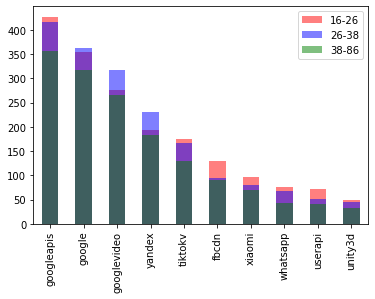

In [105]:
# Получение графиков частоты распределения доменов по возрастным группам 

ax=first_ser.value_counts()[:10].plot.bar(stacked=True, color='r', alpha=0.5)
ax=second_ser.value_counts()[:10].plot.bar(ax=ax, color='b', alpha=0.5)
ax=thied_ser.value_counts()[:10].plot.bar(ax=ax, color='g', alpha=0.5)
ax.legend(['16-26', '26-38', '38-86'])

Наиболее молодая возрастная группа является наиболее частым потребителем 

In [106]:
# Раскладывание данных суффиксов по спискам возрастных групп

first_ser=get_list(first_df.suffix)
second_ser=get_list(second_df.suffix)
thied_ser=get_list(thied_df.suffix)

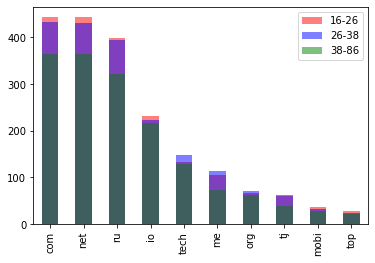

In [107]:
ax=first_ser.value_counts()[:10].plot.bar(stacked=True, color='r', alpha=0.5)
ax=second_ser.value_counts()[:10].plot.bar(ax=ax, color='b', alpha=0.5)
ax=thied_ser.value_counts()[:10].plot.bar(ax=ax, color='g', alpha=0.5)
ax.legend(['16-26', '26-38', '38-86'])

In [108]:
# Рабиение датафрейма по гендеру

men_df=main_id_new.query('gender=="m"')
wmen_df=main_id_new.query('gender=="w"')

# Выделение суффиксов по гендеру

men_ser=get_list(men_df.suffix)
wmen_ser=get_list(wmen_df.suffix)

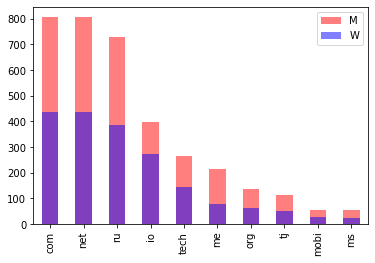

In [109]:
ax=men_ser.value_counts()[:10].plot.bar(stacked=True, color='r', alpha=0.5)
ax=wmen_ser.value_counts()[:10].plot.bar(ax=ax, color='b', alpha=0.5)
ax.legend(['M', 'W'])

In [110]:
# Выделение доменов по гендеру

men_ser=get_list(men_df.domain)
wmen_ser=get_list(wmen_df.domain)

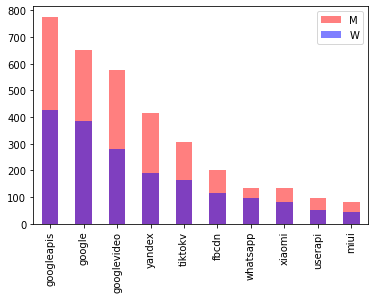

In [111]:
ax=men_ser.value_counts()[:10].plot.bar(stacked=True, color='r', alpha=0.5)
ax=wmen_ser.value_counts()[:10].plot.bar(ax=ax, color='b', alpha=0.5)
ax.legend(['M', 'W'])

# Рекомендации

* При формировании наборов данных по опциям следует отмечать отсутствие подключённой опции значением 0, а не NaN. Поскольку значения NaN могут сформироваться в случае сбоев в работе алгоритма;
* Если предоставленные данные представляют собой репрезентативную выборку, то можно сделать вывод о недостаточной вовлечённости первой и третьей группы клиентов. Можно решить соответствующим таргетированным стимулированием, формированием индивидуальной ценовой политики, например, тарифы для школьников и пенсионеров;
* Если id региона выделяется отдельно для различных населённых пунктов, то можно отметить, что в некоторых населённых пунктах t-cell на рынке сотовых операторов представлен недостаточно. Решается расширением географии доступности сети t-cell, при прочих равных для различных населённых пунктов;
* Интересно было бы исследовать данные по клиентам в динамике, в том числе данные по доходу. Возможно, динамика клиентских трат в значительной степени характеризует возрастную категорию клиента;

* Данные по тарифам (условия) помогли бы интерпретировать популярность нескольких тарифов и сделать вывовы о способах и необходимости изменения тарифной политики компании;
* Оптимизировать дополнительные платные опции - многие опции просто не используются (используются редко)
